# The "Loop"-experiment

The [Loop Based Architecture](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.113.120501) is a photonic experiment, that allows scalable implementation Boson Sampling and arbitrary unitaries on a photonic platform.
It can be implemented as a single, sequenced or nested architecture (see figures).
It promises better scalability, as a nested sequence of two loops are able to implement an arbitrary sized unitary on time-bin encoded qubits.

<table><tr><td>
<!--![Single Loop](https://journals.aps.org/prl/article/10.1103/PhysRevLett.113.120501/figures/1/medium) -->
    <img src="https://journals.aps.org/prl/article/10.1103/PhysRevLett.113.120501/figures/1/medium" alt="Single Loop"/>
    <br><center><h3>Fig. 1 Single Loop</h3></center>
    </td><td>    
    <img src="https://journals.aps.org/prl/article/10.1103/PhysRevLett.113.120501/figures/5/medium" alt="Nested Loop"/><br><center><h3>Fig. 2 Nested Loop</h3></center>
<!--![Double Loop](https://journals.aps.org/prl/article/10.1103/PhysRevLett.113.120501/figures/5/medium)|-->
    </td></tr></table>

# 1. Creating a circuit
We use the python framework [Perceval](https://perceval.quandela.net/docs) to simulate our experiments.
We simulate the conversion of the time-bin encoded setup as path encoded photonic qubits (see Fig. 1 (b) )

### 1.1 Perfect Case / No Losses
#### 1.1.1 Three Photons that "loop" six times and create an interferometer of 3 photons in 6 modes

**Parameters of the "Loop" class:**
- _width:_ number of modes, that corresponds to the number of time-bins _n_ in Fig. 1 (a)
- _depth:_ the number of outer loops (see Fig.2)
- _phs_in:_ the number time bins with photons
- _phs_out:_ the number of photons which should be detected at the output of the circuit (_"clicks"_ on the detector)
- _in_state:_ specifies, which time-bins include a photon (if width < phs_in)

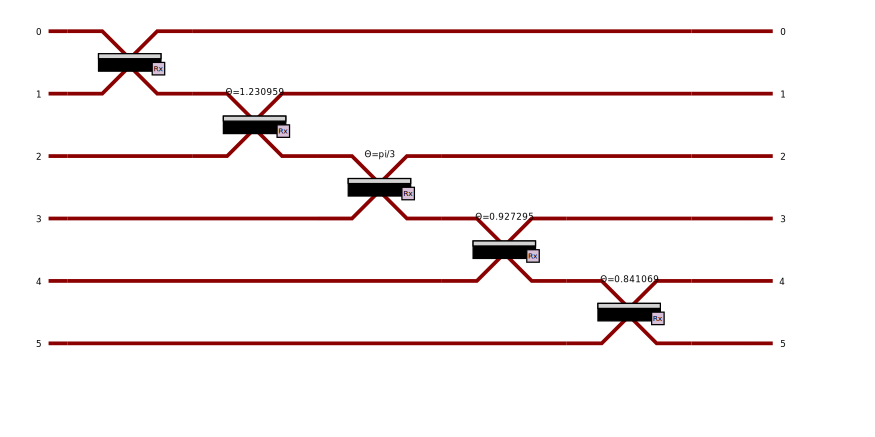

In [38]:
import perceval as pcvl
from extraction.Loop import *

l = Loop(width=6,depth=1, phs_in=3,phs_out=3,in_state=[1,0,1,0,1,0])
pcvl.pdisplay(l.experiment_circuit)

#### 1.1.1 Three Photons that "loop" six times in the inner loop and twice in the outer loop to create an interferometer of 3 photons in 6 modes

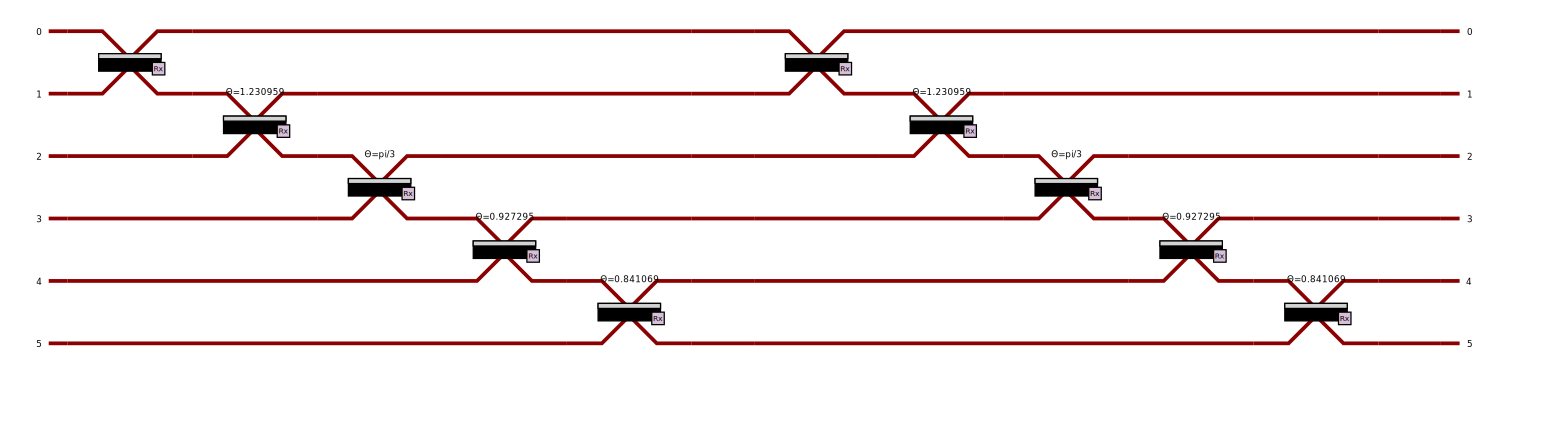

In [29]:
import perceval as pcvl
from extraction.Loop import *

l = Loop(width=6,depth=2, phs_in=3,phs_out=3,in_state=[1,0,1,0,1,0])
pcvl.pdisplay(l.experiment_circuit)

### 1.2 Optical Loss (Lossy Channels):
There are 3 kind of losses:
- Loss of the source: **loss_source**
- Loss of the inner loop: **loss_inner**
- Loss of the outer loop: **loss_outer**

The losses are simulated by adding a Beamsplitter with the respective reflectivity. _Each loss ends up in a new mode in the perceval circuit_

<b> _Perceval_ has an implementation of a [loss-channel](https://perceval.quandela.net/docs/components.html#loss-channel). However, we use our own implementation of Photon loss, that is more efficient in our case and does allow us to simulate larger experiments with losses </b>

We can simulate more efficiently, as we can reduce the number of potential output states significantly, because we specify the number of in- and output photons and calculate the output states based on that. With that, our photonic circuit is purely **unitary** while the default implementation of percevals loss-channel is defined as **non-unitary**

#### 1.2.1 Three Photons that “loop” six times and create an interferometer of 3 photons in 6 modes

There is a probility of loss of 20% in the inner loop

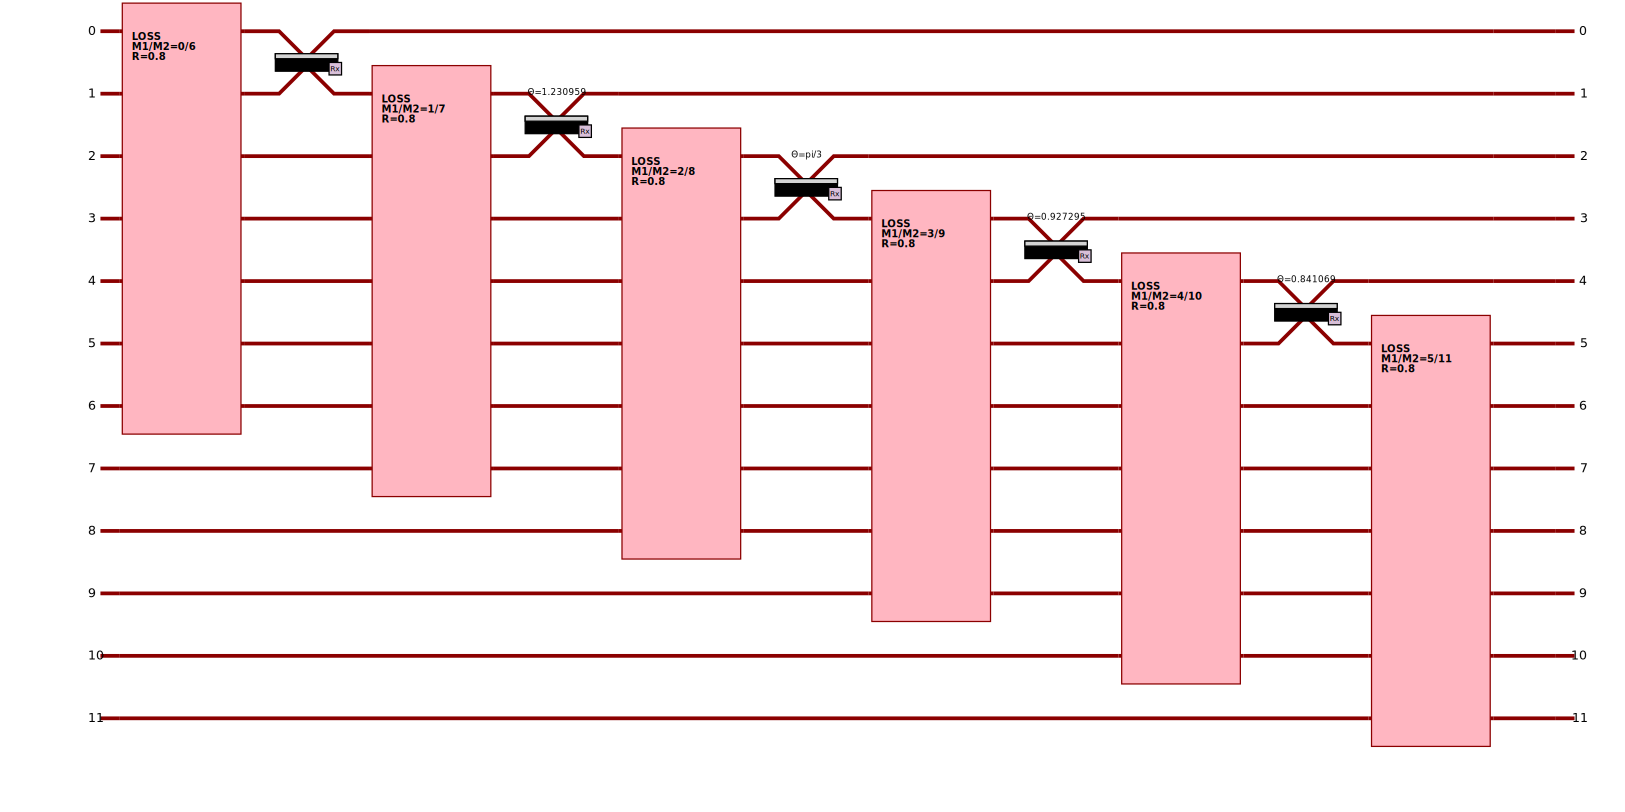

In [30]:
import perceval as pcvl
from extraction.Loop import *

l = Loop(width=6,depth=1, phs_in=3,phs_out=3,loss_loop_inner=0.2, in_state=[1,0,1,0,1,0])
pcvl.pdisplay(l.experiment_circuit)

##### Picturing the lossy channel
The lossy channel is modeled as a beam-splitter with reflectivity _r = 1.0 - loss_, that connects the respective input mode with an ancilla mode that captures if a photon got lost in a channel.
This ancilla modes are only used once, so for every lossy channel a new ancilla mode is created.

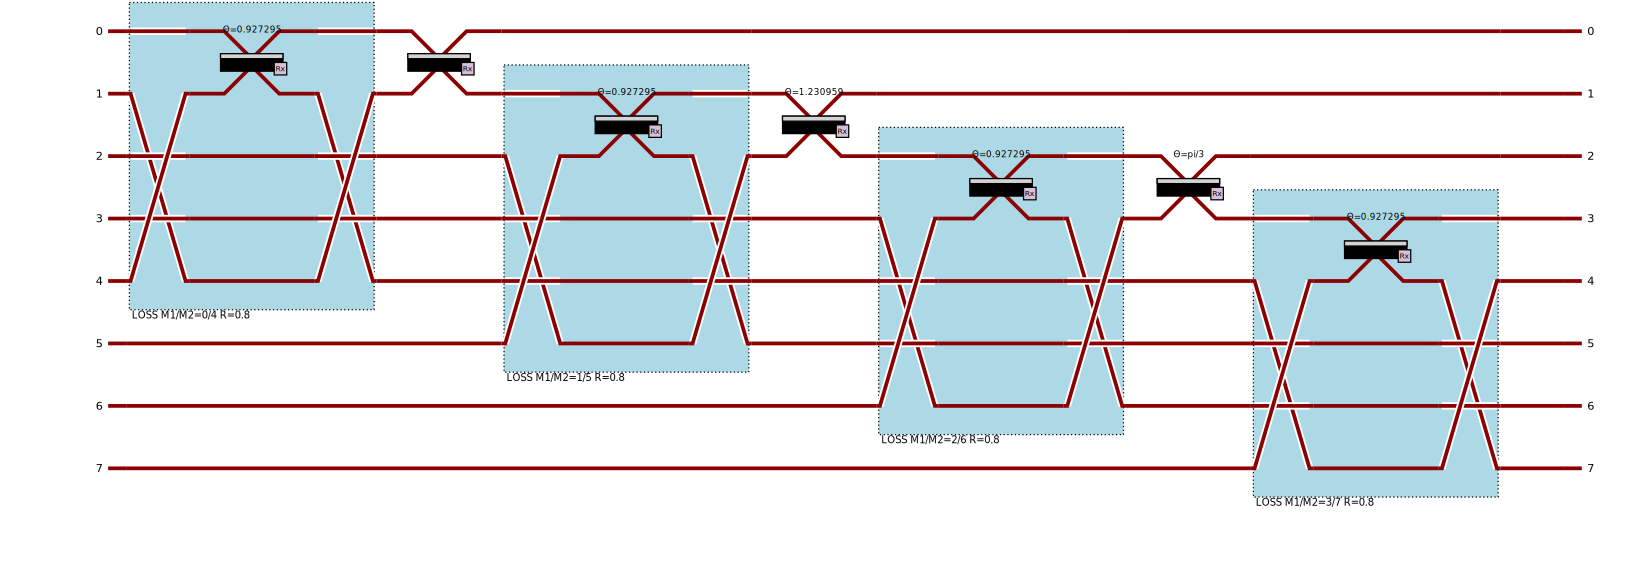

In [41]:
import perceval as pcvl
from extraction.Loop import *

l = Loop(width=4,depth=1, phs_in=3,phs_out=3,loss_loop_inner=0.2, in_state=[1,0,1,0])
pcvl.pdisplay(l.experiment_circuit, recursive=True)

#### 1.2.2 Three Photons that “loop” six times in two "outer loops" to create an interferometer of 3 photons in 6 modes

Losses are losses on source (75%), inner loop (20%) and outer loop (25%)

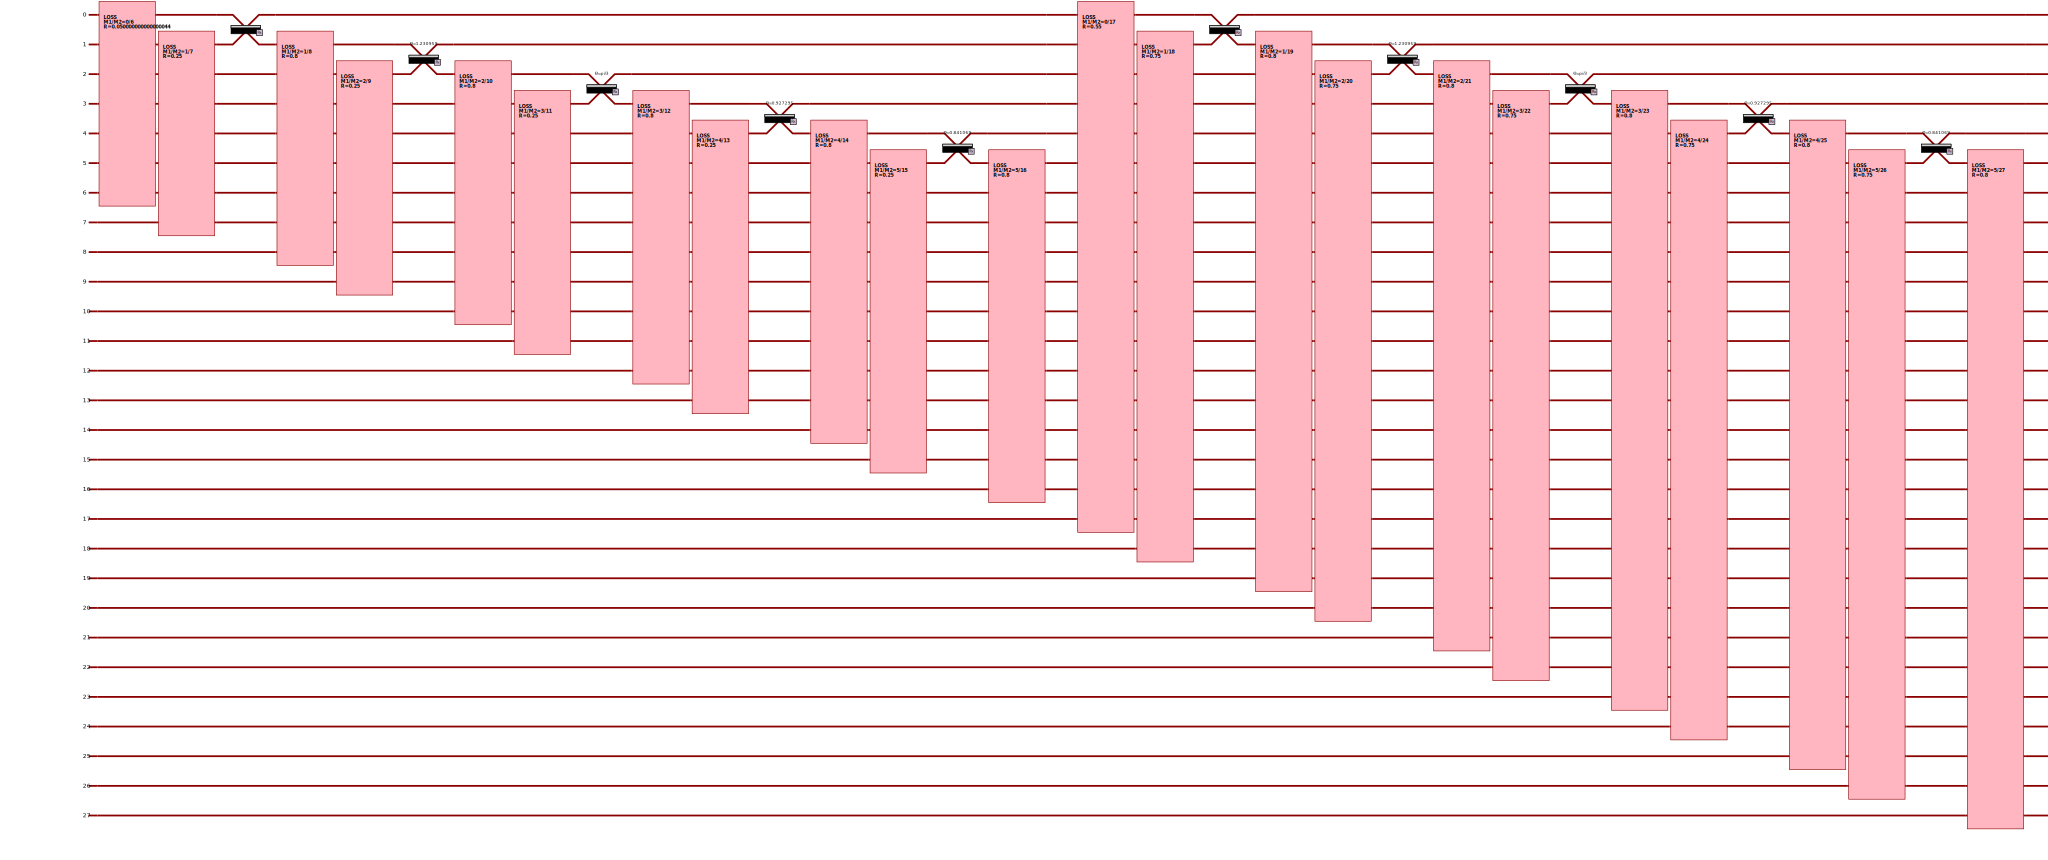

In [31]:
import perceval as pcvl
from extraction.Loop import *

l = Loop(width=6,depth=2, phs_in=3,phs_out=3,loss_Source=0.75, loss_loop_inner=0.2, loss_loop_outer=0.25, in_state=[1,0,1,0,1,0])
pcvl.pdisplay(l.experiment_circuit)

### 1.3 Photon loss
Our implementation allows simulating experiments with and without photon loss -- aka, that less photons are detects as _clicks_ as we input states. This can be specified by the parameters _phs_in_ and _phs_out_ of the _Loop_ class

There is no difference in the simulated circuit, but the calculated output states change


In [32]:
import perceval as pcvl
from extraction.Loop import *

l = []
for i in range(3):
    l.append(Loop(width=6,depth=1,phs_in=3,phs_out=i+1,loss_loop_inner=.2, in_state=[1,0,1,0,1,0]))

for i in range(3):
    print("Experiment with {} modes {} in- and {} output photons has {} output states".format(l[i].width, l[i].phs_in, l[i].phs_out, len(l[i].out_states)))

Experiment with 6 modes 3 in- and 1 output photons has 132 output states
Experiment with 6 modes 3 in- and 2 output photons has 120 output states
Experiment with 6 modes 3 in- and 3 output photons has 20 output states


# 2. Simulate the experiment with and without Photon Loss

**Simulation:** The simulation uses the _all_probs_ function of percevals _Naive_ backend

    backend = pcvl.BackendFactory.get_backend("Naive")(l.experiment_circuit)
    prob = sim.prob(input_state=l.in_state, output_state=xxx)


**Parallel Execution:** To simulate large experiments, it's advisable to run the simulation in parallel. This means, the calculation of the pobability of potential output states is are split among several processes from pyhtons [mulitprocessing](https://docs.python.org/3/library/multiprocessing.html) library

### 2.1 Simulating without photon loss with single process and plot distribution

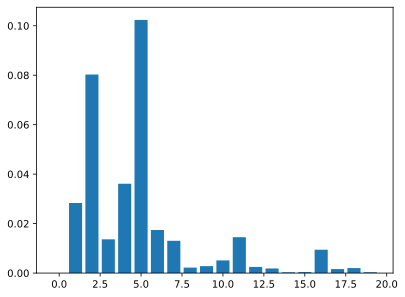

In [22]:
import perceval as pcvl
from extraction.Loop import *
import matplotlib.pyplot as plt

l = Loop(width=6,depth=1, phs_in=3,phs_out=3,loss_loop_inner=0.15, in_state=[1,0,1,0,1,0])
final_list = l.run(in_state=[1,0,1,0,1,0])

plt.bar(range(len(final_list)),final_list.values())
plt.show()

### 2.2 Simulating with photon loss on multiple processes and plot distribution

It's possible to specify the number of processes and chunks:
1. **processes=x**: the overall simulation is taken by x processes. This number should fit your CPU kernsels
2. **chunks=x**: the number of output states is devided in x chunks that are given to the processes. If there are more chunks than processes, a new chunk will be given to a new process, once the process is done. Generally, chunks and process can be the same number

calculated 0 of 2940
calculated 2940 of 2940


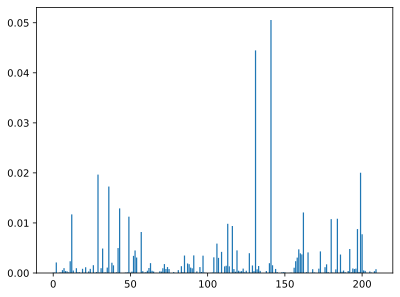

In [34]:
import perceval as pcvl
from extraction.Loop import *
import matplotlib.pyplot as plt

l = Loop(width=10,depth=1, phs_in=5,phs_out=4,loss_loop_inner=0.2, in_state=[1,0]*5)
final_list = l.run(in_state=[1,0]*5, processes=5, chunks=5)

plt.bar(range(len(final_list)),final_list.values())
plt.show()

### 2.3 Simulate Distinguishability vs. Indistinguishability

For some validation methods, it is necessary to simulate if the incoming photons do interfer or not. In other words, if the input states are indistinguishable or distinguishable.
We can simulate that, but specifying the "degree" of indistinguishability (**_Currently, only 1 and 0 are supported, partial indistinguishability is not implemented yet_**)

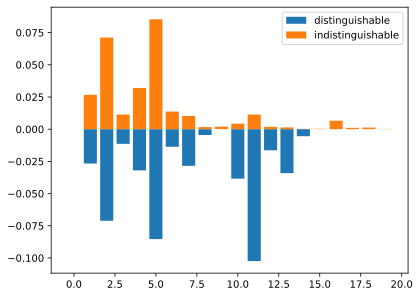

In [1]:
import perceval as pcvl
from extraction.Loop import *
import numpy as np
import matplotlib.pyplot as plt

l = Loop(width=6,depth=1, phs_in=3,phs_out=3,loss_loop_inner=0.2, in_state=[1,0]*3)
indist = l.run(indistinguishability=1)
dist = l.run(indistinguishability=0)

fig,ax = plt.subplots()

di = ax.bar(range(len(dist)), -np.array(list(dist.values())))
idi = ax.bar(range(len(indist)), indist.values())

plt.legend([di,idi], ["distinguishable", "indistinguishable"])
plt.show()